In [1]:
%matplotlib inline

This notebook contains all the necessary code to reproduce all figures in both the manuscript and the supplementary information. To obtain all the plots, run all cells in the notebook, since some cells might use previously defined information.

First, we load all necessary modules to process the data and make the plots.

In [2]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

plt.rcParams['figure.figsize'] = (16, 4)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath,amssymb,amsthm,bbm,calrsfs}']

In [3]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline

### Plotting Constants

In [4]:
tab10 = plt.get_cmap('tab10').colors
tab20b = plt.get_cmap('tab20b').colors
title_fontsize = 48
fontsize = 28
labelsize = 22
tiny_labelsize = 16
ms = 6
ms_small = 3

_2D_30_XVALS = pd.date_range("2018-12-17 00:30", "2018-12-19 00:30", freq="H", name="dates")
_XLIMS_2D = pd.Timestamp("2018-12-17"), pd.Timestamp("2018-12-19")
_1D_30_XVALS = _2D_30_XVALS[:25]
_XLIMS_1D = pd.Timestamp("2018-12-17"), pd.Timestamp("2018-12-18")

_1D_SEC_XVALS = pd.date_range("2018-12-17", "2018-12-18", freq="S")
_1D_SEC_EVALS = np.arange(-0.5, 23.5 + 1/3600, 1/3600)

_2D_SEC_XVALS = pd.date_range("2018-12-17", "2018-12-19", freq="S")
_2D_SEC_EVALS = np.arange(-0.5, 47.5 + 1 / 3600, 1 / 3600)

_IDX = pd.IndexSlice
_DIMS = ["mean", "median", "CI_low", "CI_high", "CI_83_low", "CI_83_high"]
_CONV = {s: lambda x: pd.to_datetime(x).tz_convert(None) for s in _DIMS}

### Data processing functions

In [5]:
def standardize(data):
    return (data - data.mean()) / data.std()

def wrap_circadian(array):
    return np.concatenate((array, array[0]), axis=None)


def double_circadian(array):
    return np.concatenate((array, array[1:]), axis=None)

def get_significant_hours(diff):
    above_zero = (diff.loc[:, "CI_high"] > 0) & (diff.loc[:, "CI_low"] > 0)
    below_zero = (diff.loc[:, "CI_high"] < 0) & (diff.loc[:, "CI_low"] < 0)
    return np.where(np.any([above_zero, below_zero], axis=0))[0]

def get_limits(quants_a, quants_b):
    extreme_vals = np.concatenate([quants_a.index.values[[1, -2]], quants_b.index.values[[1, -2]]], axis=None)
    return extreme_vals.min(), extreme_vals.max()

### Plot helper functions

In [6]:
def add_subplot_axes(ax, rect, show_axis=False, fc=None):
    fig = plt.gcf()
    box = ax.get_position()
    inax_position = ax.transAxes.transform(rect[0:2])
    infig_position = fig.transFigure.inverted().transform(inax_position)
    pos = [infig_position[0], infig_position[1], box.width * rect[2], box.height * rect[3]]
    subax = fig.add_axes(pos, facecolor=fc)
    if not show_axis:
        subax.set_axis_off()
    return subax

def add_sun_and_moon(ax, sun, bottom, top, zo=2):
    td = pd.Timedelta("1 day")
    ax.fill_between([_XLIMS_2D[0], sun["dawn"].loc["dawn", "median"]], bottom, top,
                    color="0.25", alpha=0.5, lw=2, linestyle="--", zorder=zo)
    ax.fill_between([sun["dusk"].loc["dusk", "median"], sun["dawn"].loc["dawn", "median"] + td], bottom, top,
                    color="0.25", alpha=0.5, lw=2, linestyle="--", zorder=zo)
    ax.fill_between([sun["dusk"].loc["dusk", "median"] + td, _XLIMS_2D[1]], bottom, top,
                    color="0.25", alpha=0.5, lw=2, linestyle="--", zorder=zo)

    ax.fill_between([sun["dawn"].loc["dawn", "median"], sun["sunrise"].loc["sunrise", "median"]], bottom, top,
                    color="0.75", alpha=0.5, lw=2, linestyle="--", zorder=zo)
    ax.fill_between([sun["sunset"].loc["sunset", "median"], sun["dusk"].loc["dusk", "median"]], bottom, top,
                    color="0.75", alpha=0.5, lw=2, linestyle="--", zorder=zo)
    ax.fill_between([sun["dawn"].loc["dawn", "median"] + td, sun["sunrise"].loc["sunrise", "median"] + td], bottom, top,
                    color="0.75", alpha=0.5, lw=2, linestyle="--", zorder=zo)
    ax.fill_between([sun["sunset"].loc["sunset", "median"] + td, sun["dusk"].loc["dusk", "median"] + td], bottom, top,
                    color="0.75", alpha=0.5, lw=2, linestyle="--", zorder=zo)

    sun = add_subplot_axes(ax, [0.225, 0.875, 0.1, 0.1])
    sun.imshow(plt.imread("figures/sun_outline.png"))

    sun2 = add_subplot_axes(ax, [0.725, 0.875, 0.1, 0.1])
    sun2.imshow(plt.imread("figures/sun_outline.png"))

    moon = add_subplot_axes(ax, [-0.05, 0.85, 0.15, 0.15])
    moon.imshow(plt.imread("figures/moon.png"))

    moon2 = add_subplot_axes(ax, [0.45, 0.85, 0.15, 0.15])
    moon2.imshow(plt.imread("figures/moon.png"))

    moon3 = add_subplot_axes(ax, [0.9, 0.85, 0.15, 0.15])
    moon3.imshow(plt.imread("figures/moon.png"))

    return ax

def add_sun_and_moon_1D_circadian(ax, sun, bottom, top, zo=2):
    ax.fill_between([_XLIMS_1D[0], sun["dawn"].loc["dawn", "median"]], bottom, top,
                    color="0.25", alpha=0.5, lw=2, linestyle="--", zorder=1)
    ax.fill_between([sun["dusk"].loc["dusk", "median"], _XLIMS_1D[1]], bottom, top,
                    color="0.25", alpha=0.5, lw=2, linestyle="--", zorder=1)

    ax.fill_between([sun["dawn"].loc["dawn", "median"], sun["sunrise"].loc["sunrise", "median"]], bottom, top,
                    color="0.75", alpha=0.5, lw=2, linestyle="--", zorder=1)
    ax.fill_between([sun["sunset"].loc["sunset", "median"], sun["dusk"].loc["dusk", "median"]], bottom, top,
                    color="0.75", alpha=0.5, lw=2, linestyle="--", zorder=1)
    
    sun1 = add_subplot_axes(ax, [0.45, 0.85, 0.1, 0.1])
    sun1.imshow(plt.imread("figures/sun_outline.png"))

    moon1 = add_subplot_axes(ax, [-0.05, 0.85, 0.15, 0.15])
    moon1.imshow(plt.imread("figures/moon.png"))

    moon2 = add_subplot_axes(ax, [0.9, 0.85, 0.15, 0.15])
    moon2.imshow(plt.imread("figures/moon.png"))
    
    return ax

def add_sun_and_moon_1D(ax, sun, color, zo=2):
    for sm in ["dawn", "sunrise", "sunset", "dusk"]:
        ax.fill_between(sun[sm].loc[sm, ["CI_low", "CI_high"]], 0, 1,
                        linestyle="--", color=color, zorder=2, alpha=0.5)
        ax.annotate(sm, (sun[sm].loc[sm, "median"], 0.5), rotation="vertical",
                    va="center", ha="center", color=color, size=tiny_labelsize)
    ax.fill_between([_XLIMS_1D[0], sun["dawn"].loc["dawn", "median"]], 0, 1,
                    color="0.25", alpha=0.5, lw=2, linestyle="--", zorder=1)
    ax.fill_between([sun["dusk"].loc["dusk", "median"], _XLIMS_1D[1]], 0, 1,
                    color="0.25", alpha=0.5, lw=2, linestyle="--", zorder=1)

    ax.fill_between([sun["dawn"].loc["dawn", "median"], sun["sunrise"].loc["sunrise", "median"]], 0, 1,
                    color="0.75", alpha=0.5, lw=2, linestyle="--", zorder=1)
    ax.fill_between([sun["sunset"].loc["sunset", "median"], sun["dusk"].loc["dusk", "median"]], 0, 1,
                    color="0.75", alpha=0.5, lw=2, linestyle="--", zorder=1)
    
    sun1 = add_subplot_axes(ax, [0.1, 0.1, 0.8, 0.8])
    sun1.imshow(plt.imread("figures/sun_outline.png"))

    moon1 = add_subplot_axes(ax, [-0.4, 0.05, 0.9, 0.9])
    moon1.imshow(plt.imread("figures/moon.png"))

    moon2 = add_subplot_axes(ax, [0.5, 0.05, 0.9, 0.9])
    moon2.imshow(plt.imread("figures/moon.png"))
    
    return ax

## Load the data 

### Circadian rhythm data

Circadian rhythms:

In [7]:
dep = pd.read_csv("plot_data/depression_activity.tsv", sep="\t", index_col="hour", parse_dates=True)
dep_vals = double_circadian(dep["mean"])
dep_cs = CubicSpline(np.arange(49), dep_vals)

dep_DST = pd.read_csv("plot_data/DST/depression_activity.tsv", sep="\t", index_col="hour", parse_dates=True)
dep_DST_vals = double_circadian(dep_DST["mean"])
dep_DST_cs = CubicSpline(np.arange(49), dep_DST_vals)

dep_noDST = pd.read_csv("plot_data/noDST/depression_activity.tsv", sep="\t", index_col="hour", parse_dates=True)
dep_noDST_vals = double_circadian(dep_noDST["mean"])
dep_noDST_cs = CubicSpline(np.arange(49), dep_noDST_vals)

rs = pd.read_csv("plot_data/random_sample_activity.tsv", sep="\t", index_col="hour", parse_dates=True)
rs_vals = double_circadian(rs["mean"])
rs_cs = CubicSpline(np.arange(49), rs_vals)

rs_DST = pd.read_csv("plot_data/DST/random_sample_activity.tsv", sep="\t", index_col="hour", parse_dates=True)
rs_DST_vals = double_circadian(rs_DST["mean"])
rs_DST_cs = CubicSpline(np.arange(49), rs_DST_vals)

rs_noDST = pd.read_csv("plot_data/noDST/random_sample_activity.tsv", sep="\t", index_col="hour", parse_dates=True)
rs_noDST_vals = double_circadian(rs_noDST["mean"])
rs_noDST_cs = CubicSpline(np.arange(49), rs_noDST_vals)

Sensitivity analysis for activity levels:

In [8]:
dep_activity = pd.read_csv("results/depression_activity.tsv", sep="\t", index_col="hour", parse_dates=True)
rs_activity = pd.read_csv("results/random_sample_activity.tsv", sep="\t", index_col="hour", parse_dates=True)

tweetbin = 60
bins = np.arange(0, 3320, tweetbin)
min_tweets = 120

dep_counts = dep_activity.sum()
rs_counts = rs_activity.sum()

dep_normed_activity = dep_activity / dep_activity.sum()
rs_normed_activity = rs_activity / rs_activity.sum()

dep_normed_mean = wrap_circadian(dep_normed_activity.mean(axis=1))
dep_normed_cs = CubicSpline(np.arange(25), dep_normed_mean)

rs_normed_mean = wrap_circadian(rs_normed_activity.mean(axis=1))
rs_normed_cs = CubicSpline(np.arange(25), rs_normed_mean)

dep_filt_mean = wrap_circadian(dep_normed_activity.loc[:, dep_activity.sum() > min_tweets].mean(axis=1))
dep_filt_cs = CubicSpline(np.arange(25), dep_filt_mean)

rs_filt_mean = wrap_circadian(rs_normed_activity.loc[:, rs_activity.sum() > min_tweets].mean(axis=1))
rs_filt_cs = CubicSpline(np.arange(25), rs_filt_mean)

Testing for phase shift between rhythms:

In [9]:
# corr_shift_hours = np.arange(-12, 13, 3)
corr_shift_hours = np.arange(-12, 13)
sign_thr = 0.496

corr_outcomes = np.array([dep["mean"].corr(pd.Series(index=rs.index, data=np.roll(rs["mean"], x)), method="pearson") for x in corr_shift_hours])
above_sign_trh = np.where(corr_outcomes > sign_thr)[0]

min_above_thr = corr_shift_hours[above_sign_trh.min()]
max_above_thr = corr_shift_hours[above_sign_trh.max()]

np.roll(rs_vals[:-1], min_above_thr)

rs_min_thr_vals = np.concatenate([np.roll(rs_vals[:-1], min_above_thr), np.roll(rs_vals[:-1], min_above_thr)[0]], axis=None)
rs_min_thr_cs = CubicSpline(np.arange(49), rs_min_thr_vals)

rs_max_thr_vals = np.concatenate([np.roll(rs_vals[:-1], max_above_thr), np.roll(rs_vals[:-1], max_above_thr)[0]], axis=None)
rs_max_thr_cs = CubicSpline(np.arange(49), rs_max_thr_vals)

Sun daily rhythms:

In [10]:
sun = {}
sun_quants = {}
rs_sun = {}
rs_sun_quants = {}
for DST in ["all", "DST", "noDST"]:
    sun[DST] = {}
    sun_quants[DST] = {}
    rs_sun[DST] = {}
    rs_sun_quants[DST] = {}
    dst_folder = "" if DST == "all" else DST + "/"
    for dim in ["dawn", "sunrise", "sunset", "dusk"]:
        fn = "plot_data/{DST}depression_{m}.tsv".format(DST=dst_folder, m=dim)
        sun[DST][dim] = pd.read_csv(fn, sep="\t", index_col="quantity", converters=_CONV)
        
        fn = "plot_data/{DST}depression_{m}_quantiles.tsv".format(DST=dst_folder, m=dim)
        sun_quants[DST][dim] = pd.read_csv(fn, sep="\t", index_col="dates", parse_dates=True)
        
        fn = "plot_data/{DST}random_sample_{m}.tsv".format(DST=dst_folder, m=dim)
        rs_sun[DST][dim] = pd.read_csv(fn, sep="\t", index_col="quantity", converters=_CONV)
        
        fn = "plot_data/{DST}random_sample_{m}_quantiles.tsv".format(DST=dst_folder, m=dim)
        rs_sun_quants[DST][dim] = pd.read_csv(fn, sep="\t", index_col="dates", parse_dates=True)

sun_CIs = {}
rs_sun_CIs = {}        
for dim in ["dawn", "sunrise", "sunset", "dusk"]:
        CI_low = sun_quants["all"][dim].index > sun["all"][dim].loc[dim, "CI_low"]
        CI_high = sun_quants["all"][dim].index < sun["all"][dim].loc[dim, "CI_high"]
        sun_CIs[dim] = CI_low & CI_high
        
        rs_CI_low = rs_sun_quants["all"][dim].index > rs_sun["all"][dim].loc[dim, "CI_low"]
        rs_CI_high = rs_sun_quants["all"][dim].index < rs_sun["all"][dim].loc[dim, "CI_high"]
        rs_sun_CIs[dim] = rs_CI_low & rs_CI_high

### Difference data

Relative difference:

In [11]:
relative = dep.loc[:, "median"] / rs.loc[:, "median"]
relative_cs = CubicSpline(np.arange(25), relative)

Difference per bootstrap run:

In [12]:
diff = pd.read_csv("plot_data/D_vs_RS_activity.tsv", sep="\t", index_col="hour", parse_dates=True)

Calculate which differences are significant:

In [13]:
sig_diff = get_significant_hours(diff)
diff_lws = [5 if t in sig_diff else 1 for t in range(24)]
diff_mrkr = [_XLIMS_1D[0] + pd.Timedelta("{} hours".format(t)) for t in sig_diff]

_SIG_NTRVLS = []
for x in get_significant_hours(diff):
    begin = _XLIMS_1D[0] + pd.Timedelta("{} hours".format(x))
    end = _XLIMS_1D[0] + pd.Timedelta("{} hours".format(x + 1))
    _SIG_NTRVLS.append((begin, end))

### Content analysis data

Find most used tokens throughout the day:

In [14]:
rc = pd.read_csv("results/dep_vs_rs_token_count_rank.tsv", sep="\t", index_col=[0],
                 header=[0, 1], na_values=[""], keep_default_na=False)
_TOP_K = 250

dep_in_TOP_K = rc.loc[:, _IDX["depression", :]].isin(np.arange(1, _TOP_K + 1)).sum(axis=1)
rs_in_TOP_K = rc.loc[:, _IDX["random_sample", :]].isin(np.arange(1, _TOP_K + 1)).sum(axis=1)

always_in_dep = dep_in_TOP_K[dep_in_TOP_K == 24].index.values
always_in_rs = rs_in_TOP_K[rs_in_TOP_K == 24].index.values

common_tokens = np.intersect1d(always_in_dep, always_in_rs)
print("In total, we found", common_tokens.size, "that adhere to the criteria, namely:")
common_tokens

In total, we found 187 that adhere to the criteria, namely:


array(['!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '..', '...', '/',
       '2', '3', ':', '?', 'I', 'a', 'about', 'after', 'again', 'all',
       'also', 'always', 'am', 'an', 'and', 'any', 'are', 'as', 'at',
       'back', 'be', 'because', 'been', 'before', 'being', 'best',
       'better', 'but', 'by', 'can', 'come', 'could', 'day', 'did', 'do',
       'does', 'down', 'even', 'ever', 'every', 'feel', 'first', 'for',
       'from', 'get', 'getting', 'go', 'going', 'good', 'got', 'great',
       'had', 'happy', 'has', 'have', 'he', "he's", 'help', 'her', 'here',
       'him', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', "it's",
       'just', 'keep', 'know', 'last', 'let', 'life', 'like', 'lol',
       'look', 'love', 'made', 'make', 'man', 'many', 'me', 'more',
       'most', 'much', 'my', 'need', 'never', 'new', 'no', 'not', 'now',
       'of', 'off', 'oh', 'on', 'one', 'only', 'or', 'other', 'our',
       'out', 'over', 'people', 'please', 'really', 'right', 'said',
   

Define content analysis categories:

In [15]:
categories = {
    "personal": {
        "tokens": ["I", "i", "me", "my", "mine", "myself"],
        "color": tab10[4],
        "ylims": (0.7, 3.1),
        "yticks": (0.45, 0.05),
        "label": r"Personal Pronouns"
    },
    "rumination": {
        "tokens": ["could", "if", "know", "need", "only", "or", "should", "want", "will", "would"],
        "color": tab10[0],
        "ylims": (0.9, 1.9),
        "yticks": (0.2, 0.05),
        "label": r"Rumination"
    },
    "pos_affect": {
        "tokens": ["good", "happy", "hope", "like", "love", "thank", "thanks", "well", "better",
                   ":)", ":D", "❤", "😂", "🤣", "😀", "😁", "😄", "🙂"],
        "color": tab10[2],
        "ylims": (0.2, 3.3),
        "yticks": (0.7, 0.1),
        "label": r"Positive Affect"
    },
    "neg_affect": {
        "tokens": ["shit", "bad", "sad", "angry", "cry", "crying", "worse", "worst", "horrible",
                   "terrible", "frustrated", "annoyed", "overwhelmed", "stressed",
                   ":(", ":'(", "😭", "😢", "😰", "😞", "😟", "😠", "😡"],
        "color": tab10[3],
        "ylims": (0, 6.5),
        "yticks": (1, 0.1),
        "label": r"Negative Affect"
    },
    "questioning": {
        "tokens": ["how", "think", "what", "when", "who", "why", "where"],
        "color": tab10[5],
        "ylims": (0.95, 1.75),
        "yticks": (0.3, 0.05),
        "label": r"Questioning"
    },
    "rigid_think": {
        "tokens": ["all", "always", "because", "even", "ever", "more", "much", "never",
               "no", "not", "really", "still"],
        "color": tab10[1],
        "ylims": (0.4, 2.6),
        "yticks": (0.7, 0.1),
        "label": r"Rigid Thinking"
    },
}

Define combined content analysis tokens:

In [16]:
all_tokens = np.concatenate([categories[k]["tokens"] for k in categories], axis=None)
categories["all"] = {
    "tokens": all_tokens,
    "color": "k",
    "ylims": (0, 6.5),
    "yticks": (1, 0.1),
    "label": r"All selected tokens"
}

Per token relative hourly usage:

In [17]:
rf = pd.read_csv("results/dep_vs_rs_token_relative_frequency.tsv", sep="\t", index_col=[0],
                 header=[0, 1], na_values=[""], keep_default_na=False)

data_rf = rf.loc[:, _IDX["depression", :]].values / rf.loc[:, _IDX["random_sample", :]].values
dep_rs_rel = pd.DataFrame(index=rf.index, columns=np.arange(24), data=data_rf)

Per token relative usage:

In [18]:
c = pd.read_csv("results/dep_vs_rs_token_count.tsv", sep="\t", index_col=[0],
                header=[0, 1], na_values=[""], keep_default_na=False)

dep_ct = c.loc[:, _IDX["depression", :]].sum(axis=1)
rs_ct = c.loc[:, _IDX["random_sample", :]].sum(axis=1)
num_dep = (c.loc[:, _IDX["depression", :]] / rf.loc[:, _IDX["depression", :]]).mean().sum()
num_rs = (c.loc[:, _IDX["random_sample", :]] / rf.loc[:, _IDX["random_sample", :]]).mean().sum()

total_or_drs = (dep_ct / num_dep) / (rs_ct / num_rs)

### Diagnosis distribution

In [19]:
user_info = pd.read_csv("data/before_after_timeline_info_depression.tsv", sep="\t", index_col="user_id")

with_diagnosis = pd.read_csv("results/diagnosis_interval_distribution.tsv", sep="\t", index_col="user_id")
users_with_diag_in_tl = user_info[user_info.diag_in_tl == True].diag_start.dropna().index
tz_diag_users = with_diagnosis[~with_diagnosis.TZ.isna()].index

with_diag = with_diagnosis.loc[np.intersect1d(tz_diag_users, users_with_diag_in_tl), :].copy()

exact_diag_users = with_diag[with_diag.relative_diag_end == with_diag.relative_diag_start].index

diag_plot_data = with_diag.loc[:, "expected_diag"]

diag_zoom_cutoff = -370

## Make the figures

Each Figure will be constructed in the code below. The code is constructed in such a way that each Figure can be made separately from here on. All cells above this cell will have to be executed to be able to produce each plot.

### Figure 1

/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


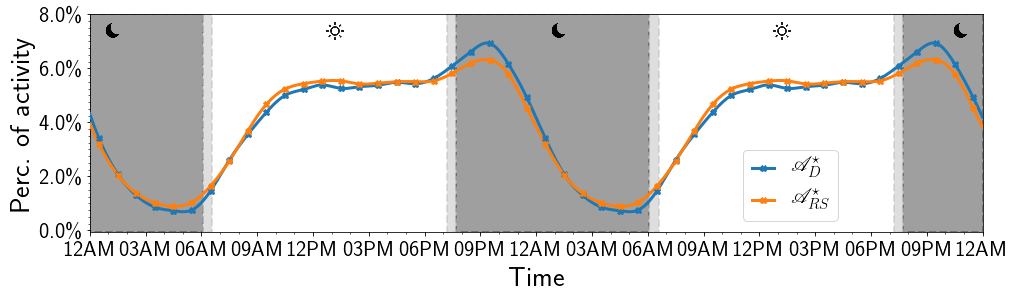

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(_2D_SEC_XVALS, 100 * dep_cs(_2D_SEC_EVALS), lw=3, color=tab10[0], zorder=3)
ax.plot(_2D_30_XVALS, 100 * dep_vals, color=tab10[0], lw=0, linestyle="-", zorder=4, marker="X", ms=ms)

ax.plot(_2D_SEC_XVALS, 100 * rs_cs(_2D_SEC_EVALS), lw=3, color=tab10[1], zorder=3)
ax.plot(_2D_30_XVALS, 100 * rs_vals, color=tab10[1], lw=0, linestyle="-", zorder=4, marker="X", ms=ms)

ax.set_ylim(-0.05, 8)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.yaxis.set_major_locator(mticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))

ax.set_xlim(_XLIMS_2D)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I%p"))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=np.arange(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator())

ax = add_sun_and_moon(ax, sun["all"], -0.05, 8)
ax.tick_params(labelsize=labelsize)

p1, = ax.plot([], [], lw=3, color=tab10[0], linestyle="-", marker="X", ms=ms)
p2, = ax.plot([], [], lw=3, color=tab10[1], linestyle="-", marker="X", ms=ms)
ax.legend([p1, p2], [r"$\mathcal{A}^\star_D$", r"$\mathcal{A}^\star_{RS}$"], fontsize=labelsize,
          bbox_to_anchor=(0.85, 0.0), ncol=1, loc="lower right", handlelength=1)

ax.set_ylabel(r"Perc. of activity", fontsize=fontsize)
ax.set_xlabel(r"Time", fontsize=fontsize)

fn = "figures/Fig1.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait', papertype='letter', bbox_inches='tight')
fig.savefig("figures/Fig1.eps", dpi=600, facecolor='w', edgecolor='w', bbox_inches='tight',
            orientation='portrait', papertype='letter')

### Figure 2

/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


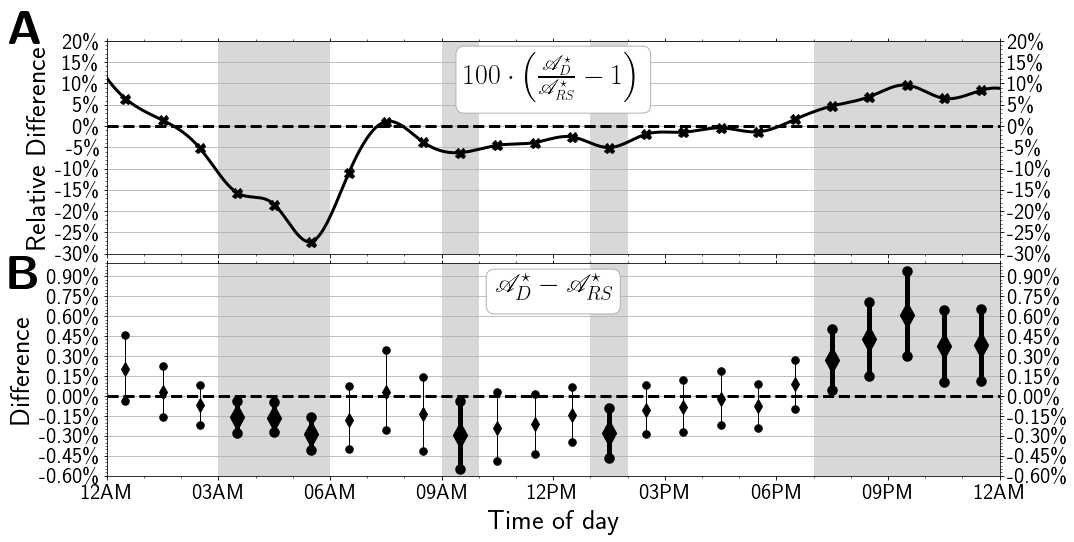

In [21]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(8, 1)

ax = fig.add_subplot(gs[:4, :])

ax.plot(_1D_30_XVALS, 100 * (relative - 1), color="k", lw=0, ms=10, marker="X", zorder=3)
ax.plot(_1D_SEC_XVALS, 100 * (relative_cs(_1D_SEC_EVALS) - 1), lw=3, color="k", zorder=4)

ax.plot(_XLIMS_1D, [0, 0], linestyle="--", lw=3, color="k", zorder=2)

for (start, end) in _SIG_NTRVLS:
    ax.fill_between([start, end], -30, 20, lw=0, color="0.7", alpha=0.5, zorder=0)

ax.tick_params(which="both", labelsize=labelsize, top=True, right=True, labelright=True)
ax.grid(b=True, axis="y", zorder=1)
    
ax.set_ylim(-30, 20)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.yaxis.set_major_locator(mticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mticker.MultipleLocator())

ax.set_xlim(_XLIMS_1D)
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())

ax.set_title(r"$100\cdot\left(\frac{\mathcal{A}^\star_D}{\mathcal{A}^\star_{RS}}-1\right)$", fontsize=fontsize, y=0.7,
             bbox=dict(boxstyle="round", pad=0.3, fc="w", ec="0.7"))
ax.set_ylabel(r"Relative Difference", fontsize=fontsize)


ax = fig.add_subplot(gs[4:])

ax.plot(_1D_30_XVALS, diff["median"], color="k", lw=0, ms=10, marker="d", zorder=3)
ax.plot(_1D_30_XVALS, diff["CI_low"], color="k", lw=0, ms=15, marker=".", zorder=3)
ax.plot(_1D_30_XVALS, diff["CI_high"], color="k", lw=0, ms=15, marker=".", zorder=3)
ax.vlines(_1D_30_XVALS, diff["CI_low"], diff["CI_high"],
          lw=diff_lws, color="k")
ax.plot(_1D_30_XVALS[sig_diff], diff.loc[diff_mrkr, "median"], color="k", lw=0, ms=15,
        marker="d", markeredgewidth=3, zorder=3)
ax.plot(_1D_30_XVALS[sig_diff], diff.loc[diff_mrkr, "CI_low"], color="k", lw=0, ms=15,
        marker=".", markeredgewidth=3, zorder=3)
ax.plot(_1D_30_XVALS[sig_diff], diff.loc[diff_mrkr, "CI_high"], color="k", lw=0, ms=15,
        marker=".", markeredgewidth=3, zorder=3)

ax.plot(_XLIMS_1D, [0, 0], linestyle="--", lw=3, color="k", zorder=2)

for (start, end) in _SIG_NTRVLS:
    ax.fill_between([start, end], -0.6, 1, lw=0, color="0.7", alpha=0.5, zorder=0)

ax.tick_params(which="both", labelsize=labelsize, top=True, right=True, labelright=True)
ax.grid(b=True, axis="y", zorder=1)
    
ax.set_ylim(-0.6, 1)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.15))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.025))

ax.set_xlim(_XLIMS_1D)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I%p"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())

ax.set_title(r"$\mathcal{A}^\star_D - \mathcal{A}^\star_{RS}$", fontsize=fontsize, y=0.8,
             bbox=dict(boxstyle="round", pad=0.3, fc="w", ec="0.7"))
ax.set_xlabel(r"Time of day", fontsize=fontsize)
ax.set_ylabel(r"Difference", fontsize=fontsize)

fig.text(0.04, 0.875, r"\textbf{A}", fontsize=title_fontsize, zorder=6)
fig.text(0.04, 0.45, r"\textbf{B}", fontsize=title_fontsize, zorder=6)

fn = "figures/Fig2.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait', papertype='letter', bbox_inches='tight')
fig.savefig("figures/Fig2.eps", dpi=600, facecolor='w', edgecolor='w', bbox_inches='tight',
            orientation='portrait', papertype='letter')

### Figure 3

/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


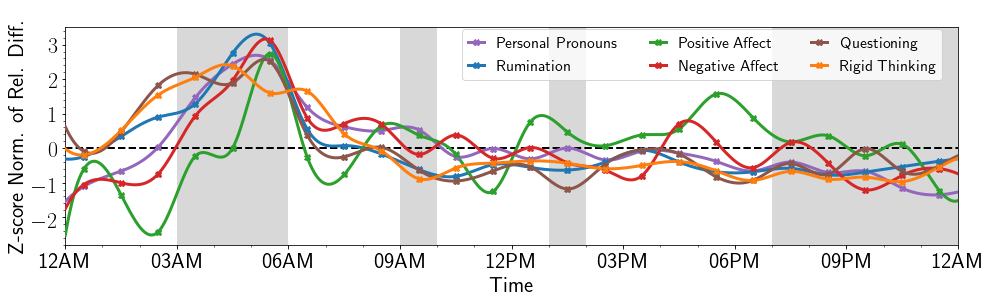

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

for k in [k for k in categories if k != "all"]:
    vals = standardize(wrap_circadian(dep_rs_rel.loc[categories[k]["tokens"], :].mean()))
    cs = CubicSpline(np.arange(25), vals)
    ax.step(_1D_30_XVALS, vals, color=categories[k]["color"], lw=0, marker="X", ms=ms, zorder=5)
    ax.plot(_1D_SEC_XVALS, cs(_1D_SEC_EVALS), lw=3, color=categories[k]["color"], zorder=4)

ax.plot([_XLIMS_1D[0], _XLIMS_1D[1]], [0, 0], lw=2, linestyle="--", color="k", zorder=2)
for (start, end) in _SIG_NTRVLS:
    ax.fill_between([start, end], -2.8, 3.5, lw=0, color="0.7", alpha=0.5, zorder=0)

ax.set_xlim(_XLIMS_1D[0], _XLIMS_1D[1])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I%p"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.2))
ax.set_ylim(-2.8, 3.5)
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Time", fontsize=labelsize)
ax.set_ylabel(r"Z-score Norm. of Rel. Diff.", fontsize=labelsize)
_LABELS = [categories[k]["label"] for k in categories if k != "all"]
_HANDLES = [ax.plot([], [], lw=3, marker="X", ms=ms, color=categories[k]["color"])[0] for k in categories if k != "all"]
fig.legend(_HANDLES, _LABELS, ncol=3, bbox_to_anchor=(0.825, 0.98),
           loc="upper right", fontsize=tiny_labelsize, handlelength=1)

fn = "figures/Fig3.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait', papertype='letter', bbox_inches='tight')
fig.savefig("figures/Fig3.eps", dpi=600, facecolor='w', edgecolor='w', bbox_inches='tight',
            orientation='portrait', papertype='letter')

### Figure S1

/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


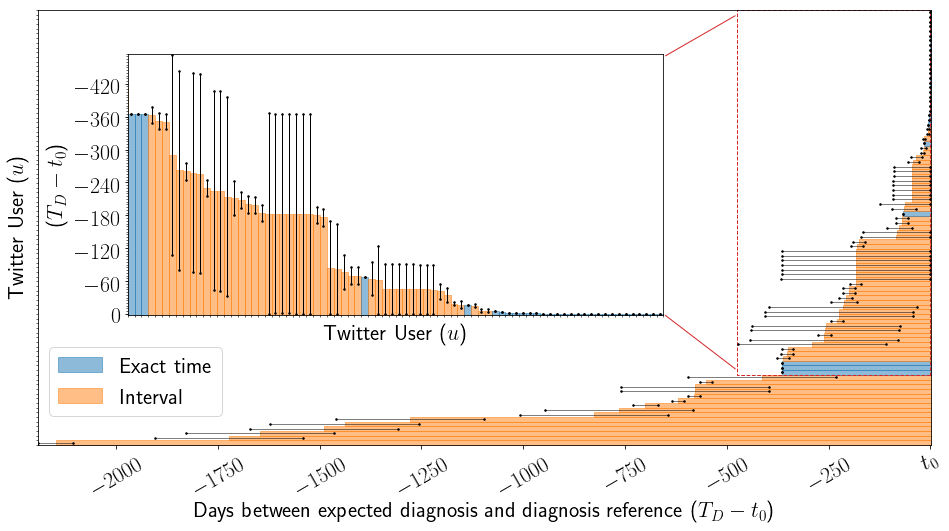

In [23]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
subax = add_subplot_axes(ax, [0.1, 0.3, 0.6, 0.6], show_axis=True)

for i, (uid, val) in enumerate(diag_plot_data.sort_values().iteritems()):
    c = tab10[0] if uid in exact_diag_users else tab10[1]
    ax.fill_between([val, 5], i + 1, y2=i, color=c, lw=1, alpha=0.5)
    ax.plot(with_diag.loc[uid, ["relative_diag_start", "relative_diag_end"]], 2 * [i + 0.5], 
            color="k", lw=0.5, marker=".", ms=3)
    subax.fill_betweenx([val, 5], i+1, x2=i, color=c, lw=1, alpha=0.5)
    subax.plot(2 * [i + 0.5], with_diag.loc[uid, ["relative_diag_start", "relative_diag_end"]],
               color="k", lw=1, marker=".", ms=3)
    

ax.set_xlabel(r"Days between expected diagnosis and diagnosis reference ($T_{D} - t_0$)", fontsize=labelsize)
ax.set_xlim(with_diag.loc[np.intersect1d(tz_diag_users, with_diag.index), "relative_diag_start"].min(), 2.5)
# ax.xaxis.set_major_locator(mticker.MultipleLocator(365))
# ax.xaxis.set_minor_locator(mticker.MultipleLocator(5))
ax.set_xticklabels([r"${}$".format(int(x)) if x < 0 else r"$t_0$" for x in ax.get_xticks()])
ax.set_ylabel(r"Twitter User ($u$)", fontsize=labelsize)
ax.set_ylim(0, diag_plot_data.shape[0])
ax.yaxis.set_major_formatter(mticker.NullFormatter())
ax.yaxis.set_major_locator(mticker.NullLocator())
ax.yaxis.set_minor_locator(mticker.MultipleLocator())
ax.tick_params(axis="x", labelsize=labelsize, labelrotation=30)


idx_cutoff = np.where(diag_plot_data.sort_values() > diag_zoom_cutoff)[0].min()

rect_xy = (0, idx_cutoff)
rect_width = with_diag.loc[diag_plot_data.sort_values().index[idx_cutoff:], "relative_diag_start"].min() // 5 * 5
rect_height = diag_plot_data.shape[0] - idx_cutoff

rect = mpl.patches.Rectangle(rect_xy, rect_width, rect_height, lw=1, linestyle="--", ec=tab10[3], fc='none')
ax.add_patch(rect)
ax.annotate("", xytext=(rect_width, diag_plot_data.shape[0] - 1),
            xy=(-655, idx_cutoff + rect_height / 2 + 29),
            arrowprops=dict(arrowstyle="-", linestyle="-", color=tab10[3]))
ax.annotate("", xytext=(rect_width, idx_cutoff + 1),
            xy=(-655, idx_cutoff + rect_height / 2 - 26),
            arrowprops=dict(arrowstyle="-", linestyle="-", color=tab10[3]))

subax.set_ylabel(r"($T_{D} - t_0$)", fontsize=labelsize)
subax.set_ylim(rect_width, 1)
subax.yaxis.set_major_locator(mticker.MultipleLocator(60))
subax.yaxis.set_minor_locator(mticker.MultipleLocator(5))
subax.invert_yaxis()
subax.set_xlabel(r"Twitter User ($u$)", fontsize=labelsize)
subax.set_xlim(idx_cutoff, diag_plot_data.shape[0])
subax.xaxis.set_major_formatter(mticker.NullFormatter())
subax.xaxis.set_major_locator(mticker.NullLocator())
subax.xaxis.set_minor_locator(mticker.MultipleLocator())
subax.tick_params(labelsize=labelsize)

lab1 = ax.fill_between([], [], y2=[], color=tab10[0], lw=1, alpha=0.5)
lab2 = ax.fill_between([], [], y2=[], color=tab10[1], lw=1, alpha=0.5)
ax.legend([lab1, lab2], ["Exact time", "Interval"], bbox_to_anchor=(0.0, 0.25), loc="upper left", fontsize=labelsize)

fn = "figures/FigS1.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait', papertype='letter', bbox_inches='tight')

### Figure S2

/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/mtenthij/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


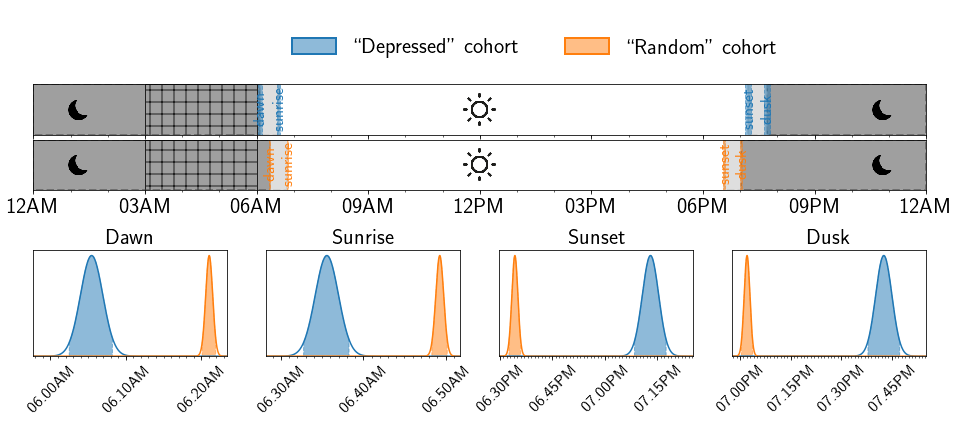

In [24]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(10, 4)

ax = fig.add_subplot(gs[:2, :])
ax = add_sun_and_moon_1D(ax, sun["all"], tab10[0])
ax.fill_between([pd.Timestamp("2018-12-17 03:00"), pd.Timestamp("2018-12-17 06:00")], 0, 1,
                lw=1, facecolor='none', edgecolor="k", hatch="+", alpha=1, zorder=0)

ax.set_xlim(_XLIMS_1D)
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.tick_params(labelsize=labelsize)


ax = fig.add_subplot(gs[2:4, :])
ax = add_sun_and_moon_1D(ax, rs_sun["all"], tab10[1])
ax.fill_between([pd.Timestamp("2018-12-17 03:00"), pd.Timestamp("2018-12-17 06:00")], 0, 1,
                lw=1, facecolor='none', edgecolor="k", hatch="+", alpha=1, zorder=0)

ax.set_xlim(_XLIMS_1D)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I%p"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.tick_params(labelsize=labelsize)

ax = fig.add_subplot(gs[6:, 0])
ax.set_title(r"Dawn", fontsize=labelsize)
ax.plot(sun_quants["all"]["dawn"].index, sun_quants["all"]["dawn"]["values"], color=tab10[0], zorder=2)
ax.plot(rs_sun_quants["all"]["dawn"].index, rs_sun_quants["all"]["dawn"]["values"], color=tab10[1], zorder=2)
ax.fill_between(sun_quants["all"]["dawn"].index, sun_quants["all"]["dawn"]["values"],
                where=sun_CIs["dawn"], color=tab10[0], linestyle="--", zorder=2, alpha=0.5)
ax.fill_between(rs_sun_quants["all"]["dawn"].index, rs_sun_quants["all"]["dawn"]["values"],
                where=sun_CIs["dawn"], color=tab10[1], linestyle="--", zorder=2, alpha=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I.%M%p"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=np.arange(0, 60, 10)))
ax.xaxis.set_minor_locator(mdates.MinuteLocator())
ax.set_xlim(get_limits(sun_quants["all"]["dawn"], rs_sun_quants["all"]["dawn"]))
ax.set_yticks([])
ax.set_ylim((0, 0.42))
ax.tick_params(labelsize=tiny_labelsize, labelrotation=45)

ax = fig.add_subplot(gs[6:, 1])
ax.set_title(r"Sunrise", fontsize=labelsize)
ax.plot(sun_quants["all"]["sunrise"].index, sun_quants["all"]["sunrise"]["values"], color=tab10[0], zorder=2)
ax.plot(rs_sun_quants["all"]["sunrise"].index, rs_sun_quants["all"]["sunrise"]["values"], color=tab10[1], zorder=2)
ax.fill_between(sun_quants["all"]["sunrise"].index, sun_quants["all"]["sunrise"]["values"],
                where=sun_CIs["sunrise"], color=tab10[0], linestyle="--", zorder=2, alpha=0.5)
ax.fill_between(rs_sun_quants["all"]["sunrise"].index, rs_sun_quants["all"]["sunrise"]["values"],
                where=sun_CIs["sunrise"], color=tab10[1], linestyle="--", zorder=2, alpha=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I.%M%p"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=np.arange(0, 60, 10)))
ax.xaxis.set_minor_locator(mdates.MinuteLocator())
ax.set_xlim(get_limits(sun_quants["all"]["sunrise"], rs_sun_quants["all"]["sunrise"]))
ax.set_yticks([])
ax.set_ylim((0, 0.42))
ax.tick_params(labelsize=tiny_labelsize, labelrotation=45)

ax = fig.add_subplot(gs[6:, 2])
ax.set_title(r"Sunset", fontsize=labelsize)
ax.plot(sun_quants["all"]["sunset"].index, sun_quants["all"]["sunset"]["values"], color=tab10[0], zorder=2)
ax.plot(rs_sun_quants["all"]["sunset"].index, rs_sun_quants["all"]["sunset"]["values"], color=tab10[1], zorder=2)
ax.fill_between(sun_quants["all"]["sunset"].index, sun_quants["all"]["sunset"]["values"],
                where=sun_CIs["sunset"], color=tab10[0], linestyle="--", zorder=2, alpha=0.5)
ax.fill_between(rs_sun_quants["all"]["sunset"].index, rs_sun_quants["all"]["sunset"]["values"],
                where=sun_CIs["sunset"], color=tab10[1], linestyle="--", zorder=2, alpha=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I.%M%p"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=np.arange(0, 60, 15)))
ax.xaxis.set_minor_locator(mdates.MinuteLocator())
ax.set_xlim(get_limits(sun_quants["all"]["sunset"], rs_sun_quants["all"]["sunset"]))
ax.set_yticks([])
ax.set_ylim((0, 0.42))
ax.tick_params(labelsize=tiny_labelsize, labelrotation=45)

ax = fig.add_subplot(gs[6:, 3])
ax.set_title(r"Dusk", fontsize=labelsize)
ax.plot(sun_quants["all"]["dusk"].index, sun_quants["all"]["dusk"]["values"], color=tab10[0], zorder=2)
ax.plot(rs_sun_quants["all"]["dusk"].index, rs_sun_quants["all"]["dusk"]["values"], color=tab10[1], zorder=2)
ax.fill_between(sun_quants["all"]["dusk"].index, sun_quants["all"]["dusk"]["values"],
                where=sun_CIs["dusk"], color=tab10[0], linestyle="--", zorder=2, alpha=0.5)
ax.fill_between(rs_sun_quants["all"]["dusk"].index, rs_sun_quants["all"]["dusk"]["values"],
                where=sun_CIs["dusk"], color=tab10[1], linestyle="--", zorder=2, alpha=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I.%M%p"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=np.arange(0, 60, 15)))
ax.xaxis.set_minor_locator(mdates.MinuteLocator())
ax.set_xlim(get_limits(sun_quants["all"]["dusk"], rs_sun_quants["all"]["dusk"]))
ax.set_yticks([])
ax.set_ylim((0, 0.42))
ax.tick_params(labelsize=tiny_labelsize, labelrotation=45)


handles = [mpatches.Patch(ec=(*tab10[0], 1), fc=(*tab10[0], 0.5), lw=2),
           mpatches.Patch(ec=(*tab10[1], 1), fc=(*tab10[1], 0.5), lw=2)]
labels = [r"``Depressed'' cohort", r"``Random'' cohort"]
fig.legend(handles, labels, ncol=2, fontsize=labelsize, frameon=False,
           loc="upper center", bbox_to_anchor=(0.465, 1.125))

fn = "figures/FigS2.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait', papertype='letter', bbox_inches='tight')

### Figure S3

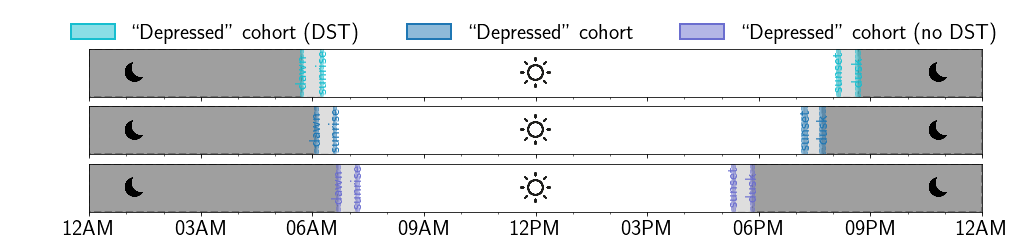

In [25]:
fig = plt.figure(figsize=(16, 3))
gs = gridspec.GridSpec(3, 1)

ax = fig.add_subplot(gs[1, :])
ax = add_sun_and_moon_1D(ax, sun["all"], tab10[0])

ax.set_xlim(_XLIMS_1D)
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.tick_params(labelsize=labelsize)

ax = fig.add_subplot(gs[0, :])
ax = add_sun_and_moon_1D(ax, sun["DST"], tab10[9])

ax.set_xlim(_XLIMS_1D)
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.tick_params(labelsize=labelsize)

ax = fig.add_subplot(gs[2, :])
ax = add_sun_and_moon_1D(ax, sun["noDST"], tab20b[2])

ax.set_xlim(_XLIMS_1D)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I%p"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.tick_params(labelsize=labelsize)
    
handles = [mpatches.Patch(ec=(*tab10[9], 1), fc=(*tab10[9], 0.5), lw=2),
           mpatches.Patch(ec=(*tab10[0], 1), fc=(*tab10[0], 0.5), lw=2),
           mpatches.Patch(ec=(*tab20b[2], 1), fc=(*tab20b[2], 0.5), lw=2)]
labels = [r"``Depressed'' cohort (DST)", r"``Depressed'' cohort", r"``Depressed'' cohort (no DST)"]
fig.legend(handles, labels, ncol=3, fontsize=labelsize, frameon=False,
           loc="upper center", bbox_to_anchor=(0.465, 1.125))

fn = "figures/FigS3.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait', papertype='letter', bbox_inches='tight')

### Figure S4

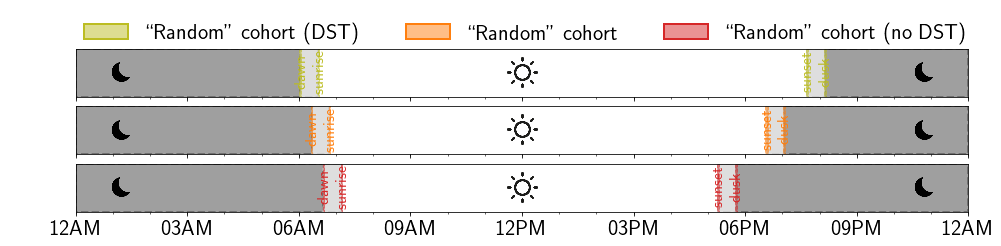

In [26]:
fig = plt.figure(figsize=(16, 3))
gs = gridspec.GridSpec(3, 1)

ax = fig.add_subplot(gs[1, :])
ax = add_sun_and_moon_1D(ax, rs_sun["all"], tab10[1])

ax.set_xlim(_XLIMS_1D)
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.tick_params(labelsize=labelsize)

ax = fig.add_subplot(gs[0, :])
ax = add_sun_and_moon_1D(ax, rs_sun["DST"], tab10[8])

ax.set_xlim(_XLIMS_1D)
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.tick_params(labelsize=labelsize)

ax = fig.add_subplot(gs[2, :])
ax = add_sun_and_moon_1D(ax, rs_sun["noDST"], tab10[3])

ax.set_xlim(_XLIMS_1D)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I%p"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.tick_params(labelsize=labelsize)
    
handles = [mpatches.Patch(ec=(*tab10[8], 1), fc=(*tab10[8], 0.5), lw=2),
           mpatches.Patch(ec=(*tab10[1], 1), fc=(*tab10[1], 0.5), lw=2),
           mpatches.Patch(ec=(*tab10[3], 1), fc=(*tab10[3], 0.5), lw=2)]
labels = [r"``Random'' cohort (DST)", r"``Random'' cohort", r"``Random'' cohort (no DST)"]
fig.legend(handles, labels, ncol=3, fontsize=labelsize, frameon=False,
           loc="upper center", bbox_to_anchor=(0.4575, 1.125))

fn = "figures/FigS4.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait',
            papertype='letter', bbox_inches='tight')

### Figure S5

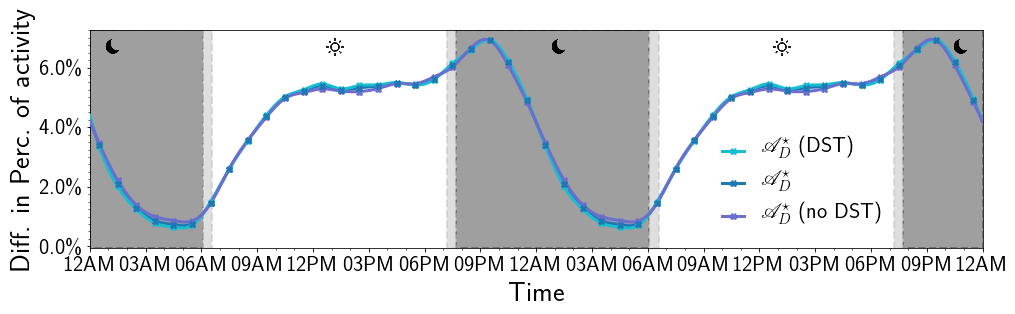

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(_2D_SEC_XVALS, 100 * dep_cs(_2D_SEC_EVALS), lw=3, color=tab10[0], zorder=3)
ax.plot(_2D_30_XVALS, 100 * dep_vals, color=tab10[0], lw=0, linestyle="-", zorder=6, marker="X", ms=ms)

ax.plot(_2D_SEC_XVALS, 100 * dep_DST_cs(_2D_SEC_EVALS), lw=3, color=tab10[9], zorder=3)
ax.plot(_2D_30_XVALS, 100 * dep_DST_vals, color=tab10[9], lw=0, linestyle="-", zorder=5, marker="X", ms=ms)

ax.plot(_2D_SEC_XVALS, 100 * dep_noDST_cs(_2D_SEC_EVALS), lw=3, color=tab20b[2], zorder=3)
ax.plot(_2D_30_XVALS, 100 * dep_noDST_vals, color=tab20b[2], lw=0, linestyle="-", zorder=4, marker="X", ms=ms)

ax.set_ylim(-0.05, 7.25)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.yaxis.set_major_locator(mticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))

ax.set_xlim(_XLIMS_2D)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I%p"))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=np.arange(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator())

ax = add_sun_and_moon(ax, sun["all"], -0.05, 7.25)
ax.tick_params(labelsize=labelsize)

p1, = ax.plot([], [], lw=3, color=tab10[0], linestyle="-", marker="X", ms=ms)
p2, = ax.plot([], [], lw=3, color=tab10[9], linestyle="-", marker="X", ms=ms)
p3, = ax.plot([], [], lw=3, color=tab20b[2], linestyle="-", marker="X", ms=ms)
ax.legend([p2, p1, p3], [r"$\mathcal{A}^\star_D$ (DST)", r"$\mathcal{A}^\star_D$", r"$\mathcal{A}^\star_D$ (no DST)"], 
          fontsize=labelsize, bbox_to_anchor=(0.91, 0.0), ncol=1, loc="lower right", handlelength=1, frameon=False)

ax.set_ylabel(r"Diff. in Perc. of activity", fontsize=fontsize)
ax.set_xlabel(r"Time", fontsize=fontsize)

fn = "figures/FigS5.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait', papertype='letter', bbox_inches='tight')

### Figure S6

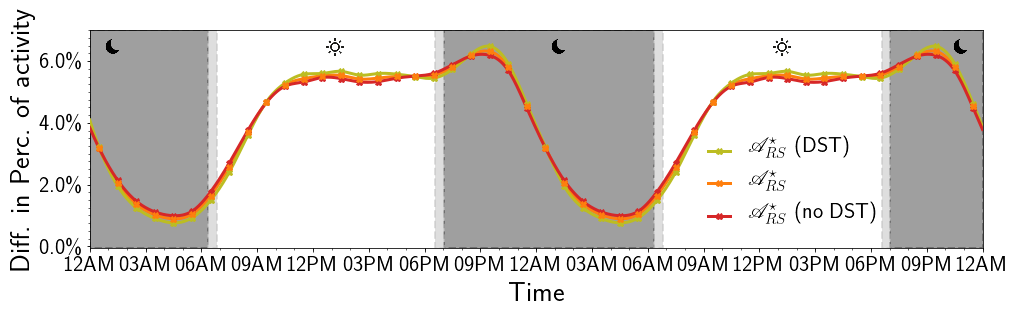

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(_2D_SEC_XVALS, 100 * rs_cs(_2D_SEC_EVALS), lw=3, color=tab10[1], zorder=3)
ax.plot(_2D_30_XVALS, 100 * rs_vals, color=tab10[1], lw=0, linestyle="-", zorder=6, marker="X", ms=ms)

ax.plot(_2D_SEC_XVALS, 100 * rs_DST_cs(_2D_SEC_EVALS), lw=3, color=tab10[8], zorder=3)
ax.plot(_2D_30_XVALS, 100 * rs_DST_vals, color=tab10[8], lw=0, linestyle="-", zorder=5, marker="X", ms=ms)

ax.plot(_2D_SEC_XVALS, 100 * rs_noDST_cs(_2D_SEC_EVALS), lw=3, color=tab10[3], zorder=3)
ax.plot(_2D_30_XVALS, 100 * rs_noDST_vals, color=tab10[3], lw=0, linestyle="-", zorder=4, marker="X", ms=ms)

ax.set_ylim(-0.05, 7)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.yaxis.set_major_locator(mticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))

ax.set_xlim(_XLIMS_2D)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I%p"))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=np.arange(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator())

ax = add_sun_and_moon(ax, rs_sun["all"], -0.05, 7)
ax.tick_params(labelsize=labelsize)

p1, = ax.plot([], [], lw=3, color=tab10[1], linestyle="-", marker="X", ms=ms)
p2, = ax.plot([], [], lw=3, color=tab10[8], linestyle="-", marker="X", ms=ms)
p3, = ax.plot([], [], lw=3, color=tab10[3], linestyle="-", marker="X", ms=ms)
ax.legend([p2, p1, p3], [r"$\mathcal{A}^\star_{RS}$ (DST)", r"$\mathcal{A}^\star_{RS}$", r"$\mathcal{A}^\star_{RS}$ (no DST)"],
          fontsize=labelsize, bbox_to_anchor=(0.905, 0.0), ncol=1, loc="lower right", handlelength=1, frameon=False)

ax.set_ylabel(r"Diff. in Perc. of activity", fontsize=fontsize)
ax.set_xlabel(r"Time", fontsize=fontsize)

fn = "figures/FigS6.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait', papertype='letter', bbox_inches='tight')

### Figure S7

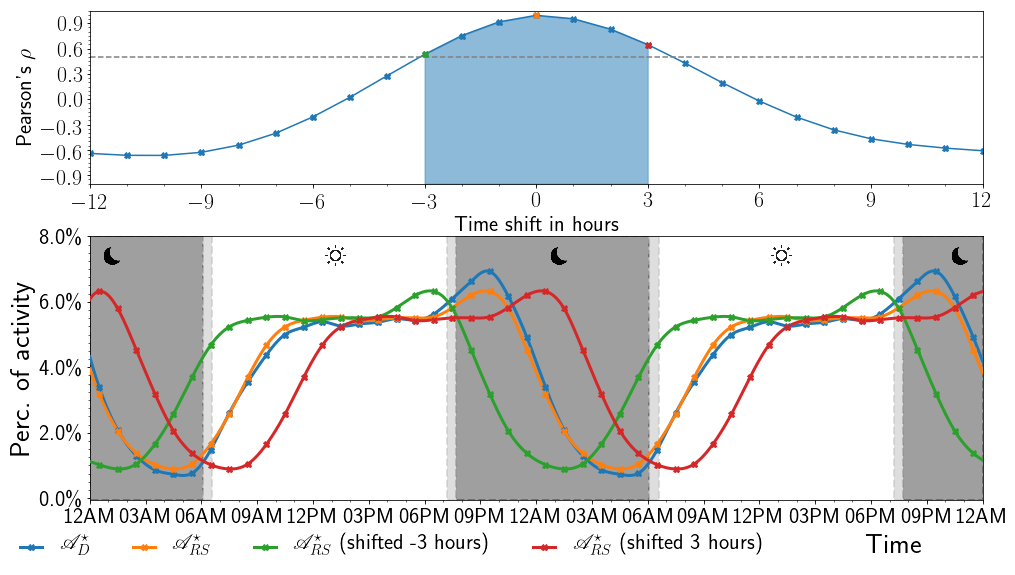

In [29]:
fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(11, 1)

ax = fig.add_subplot(gs[:4])
ax.plot(corr_shift_hours, corr_outcomes, marker="X", ms=ms, color=tab10[0])
ax.plot([-12, 12], [sign_thr, sign_thr], color="0.5", linestyle="--")
ax.fill_between(corr_shift_hours, y1=-1 * np.ones(corr_outcomes.shape), y2=corr_outcomes,
                where=corr_outcomes > sign_thr, alpha=0.5, color=tab10[0])

ax.plot(0, corr_outcomes[0+12], marker="X", ms=ms, color=tab10[1])
ax.plot(min_above_thr, corr_outcomes[min_above_thr+12], marker="X", ms=ms, color=tab10[2])
ax.plot(max_above_thr, corr_outcomes[max_above_thr+12], marker="X", ms=ms, color=tab10[3])
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Time shift in hours", size=labelsize)
ax.set_ylabel(r"Pearson's $\rho$", size=labelsize)
ax.set_ylim(-1, 1.05)
ax.set_xlim(-12, 12)
ax.xaxis.set_major_locator(mticker.MultipleLocator(3))
ax.xaxis.set_minor_locator(mticker.MultipleLocator())
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.3))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.05))

ax = fig.add_subplot(gs[5:])
ax.plot(_2D_SEC_XVALS, 100 * dep_cs(_2D_SEC_EVALS), lw=3, color=tab10[0], zorder=3)
ax.plot(_2D_30_XVALS, 100 * dep_vals, color=tab10[0], lw=0, linestyle="-", zorder=4, marker="X", ms=ms)

ax.plot(_2D_SEC_XVALS, 100 * rs_cs(_2D_SEC_EVALS), lw=3, color=tab10[1], zorder=3)
ax.plot(_2D_30_XVALS, 100 * rs_vals, color=tab10[1], lw=0, linestyle="-", zorder=4, marker="X", ms=ms)

ax.plot(_2D_SEC_XVALS, 100 * rs_min_thr_cs(_2D_SEC_EVALS), lw=3, color=tab10[2], zorder=3)
ax.plot(_2D_30_XVALS, 100 * rs_min_thr_vals, color=tab10[2], lw=0, linestyle="-", zorder=4, marker="X", ms=ms)

ax.plot(_2D_SEC_XVALS, 100 * rs_max_thr_cs(_2D_SEC_EVALS), lw=3, color=tab10[3], zorder=3)
ax.plot(_2D_30_XVALS, 100 * rs_max_thr_vals, color=tab10[3], lw=0, linestyle="-", zorder=4, marker="X", ms=ms)

ax.set_ylim(-0.05, 8)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.yaxis.set_major_locator(mticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))

ax.set_xlim(_XLIMS_2D)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%I%p"))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=np.arange(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator())

ax = add_sun_and_moon(ax, sun["all"], -0.05, 8)
ax.tick_params(labelsize=labelsize)

p1, = ax.plot([], [], lw=3, color=tab10[0], linestyle="-", marker="X", ms=ms)
p2, = ax.plot([], [], lw=3, color=tab10[1], linestyle="-", marker="X", ms=ms)
p3, = ax.plot([], [], lw=3, color=tab10[2], linestyle="-", marker="X", ms=ms)
p4, = ax.plot([], [], lw=3, color=tab10[3], linestyle="-", marker="X", ms=ms)
ax.legend([p1, p2, p3, p4], [r"$\mathcal{A}^\star_D$", r"$\mathcal{A}^\star_{RS}$",
                             r"$\mathcal{A}^\star_{RS}$"+r" (shifted {} hours)".format(min_above_thr),
                             r"$\mathcal{A}^\star_{RS}$"+r" (shifted {} hours)".format(max_above_thr)],
          fontsize=labelsize, bbox_to_anchor=(0.775, -0.3), ncol=4, loc="lower right", handlelength=1, frameon=False)

ax.set_ylabel(r"Perc. of activity", fontsize=fontsize)
ax.set_xlabel(r"Time", fontsize=fontsize, x=0.9)

fn = "figures/FigS7.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait', papertype='letter', bbox_inches='tight')

### Figure S8

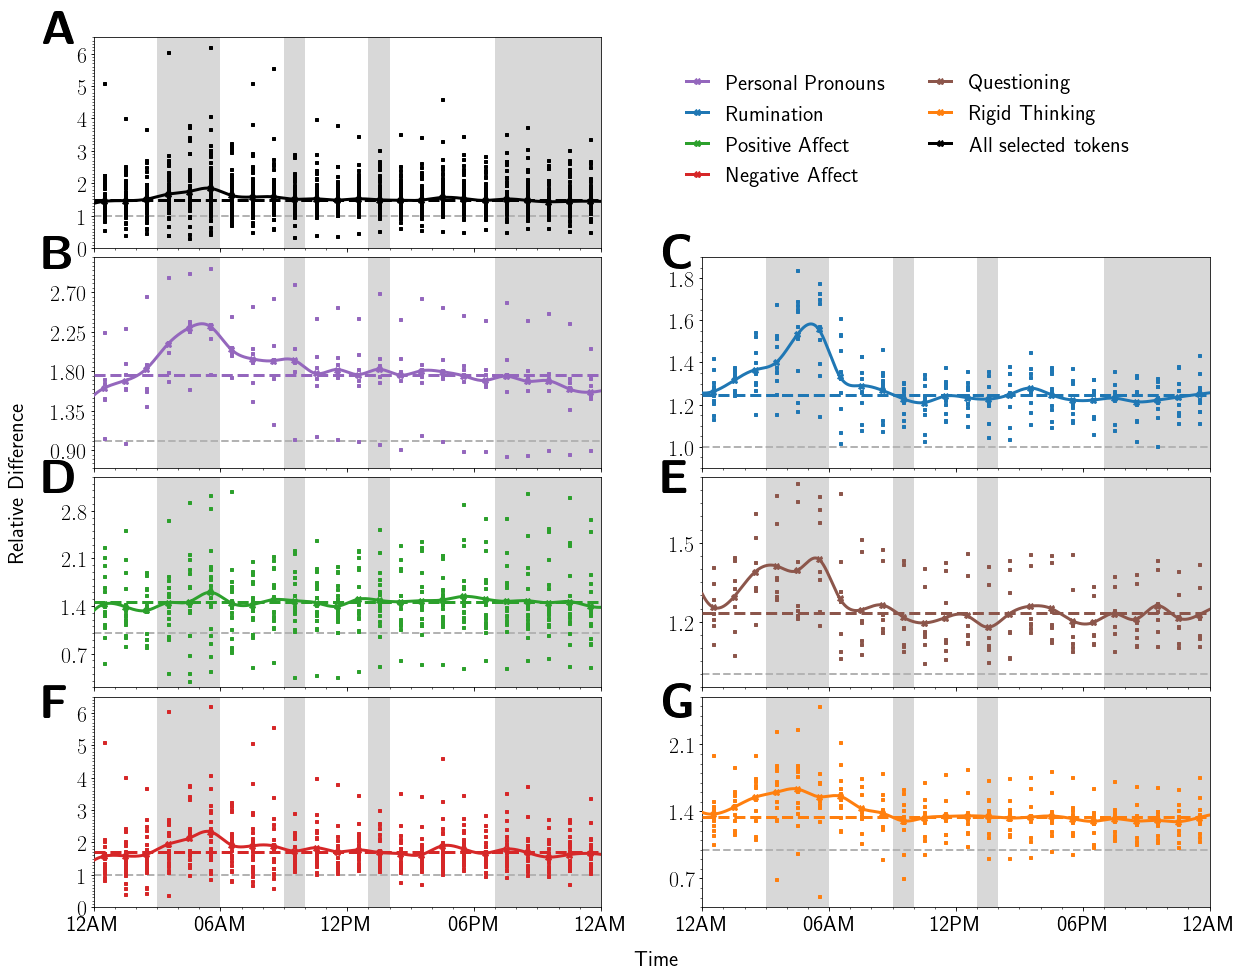

In [30]:
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(16, 2)

axes = {
    "all": fig.add_subplot(gs[:4, 0]),
    "personal": fig.add_subplot(gs[4:8, 0]),
    "rumination": fig.add_subplot(gs[4:8, 1]),
    "pos_affect": fig.add_subplot(gs[8:12, 0]),
    "neg_affect": fig.add_subplot(gs[12:, 0]),
    "questioning": fig.add_subplot(gs[8:12, 1]),
    "rigid_think": fig.add_subplot(gs[12:, 1])
}

for k in categories:
    data = categories[k]
    vals = wrap_circadian(dep_rs_rel.loc[data["tokens"], :].mean())
    overall_mean = total_or_drs[data["tokens"]].mean()
    cs = CubicSpline(np.arange(25), vals)
    
    axes[k].plot(_1D_30_XVALS, vals, color=data["color"], lw=0, marker="X", ms=ms, zorder=5)
    axes[k].plot([_XLIMS_1D[0], _XLIMS_1D[1]], 2 * [overall_mean], lw=3, linestyle="--", color=data["color"], zorder=3)
    axes[k].plot([_XLIMS_1D[0], _XLIMS_1D[1]], [1, 1], lw=2, linestyle="--", color="0.7", zorder=2)
    axes[k].plot(_1D_SEC_XVALS, cs(_1D_SEC_EVALS), lw=3, color=data["color"], zorder=4)

    for t in data["tokens"]:
        axes[k].plot(_1D_30_XVALS, wrap_circadian(dep_rs_rel.loc[t, :]), color=data["color"],
                     lw=0, ms=ms_small, marker="s", zorder=2)

    axes[k].set_xlim(_XLIMS_1D[0], _XLIMS_1D[1])
    axes[k].xaxis.set_major_formatter(mdates.DateFormatter("%I%p"))
    axes[k].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axes[k].xaxis.set_minor_locator(mdates.HourLocator())
    axes[k].yaxis.set_major_locator(mticker.MultipleLocator(data["yticks"][0]))
    axes[k].yaxis.set_minor_locator(mticker.MultipleLocator(data["yticks"][1]))

    for (start, end) in _SIG_NTRVLS:
        axes[k].fill_between([start, end], data["ylims"][0], data["ylims"][1], lw=0, color="0.7", alpha=0.5, zorder=0)

    axes[k].set_ylim(data["ylims"][0], data["ylims"][1])
    axes[k].tick_params(labelsize=labelsize)
    
    if k not in ["neg_affect", "rigid_think"]:
        axes[k].xaxis.set_major_formatter(mticker.NullFormatter())

_LABELS = [categories[k]["label"] for k in categories]
_HANDLES = [ax.plot([], [], lw=3, marker="X", ms=ms, color=categories[k]["color"])[0] for k in categories]
fig.legend(_HANDLES, _LABELS, ncol=2, bbox_to_anchor=(0.63, 0.735), loc="center",
           fontsize=labelsize, handlelength=1, frameon=False)

fig.text(0.09, 0.875, r"\textbf{A}", fontsize=title_fontsize, zorder=6)
fig.text(0.09, 0.68, r"\textbf{B}", fontsize=title_fontsize, zorder=6)
fig.text(0.52, 0.68, r"\textbf{C}", fontsize=title_fontsize, zorder=6)
fig.text(0.09, 0.485, r"\textbf{D}", fontsize=title_fontsize, zorder=6)
fig.text(0.52, 0.485, r"\textbf{E}", fontsize=title_fontsize, zorder=6)
fig.text(0.09, 0.29, r"\textbf{F}", fontsize=title_fontsize, zorder=6)
fig.text(0.52, 0.29, r"\textbf{G}", fontsize=title_fontsize, zorder=6)

fig.text(0.065, 0.55, r"Relative Difference", fontsize=labelsize, rotation="vertical")
fig.text(0.5, 0.075, r"Time", fontsize=labelsize)

fn = "figures/FigS8.pdf"
fig.savefig(fn, dpi=600, facecolor='w', edgecolor='w', orientation='portrait', papertype='letter', bbox_inches='tight')